In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# importando bibliotecas necessária para o código
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pandas import read_csv
from sklearn.metrics import classification_report, confusion_matrix 
import matplotlib.pyplot as plt
from sklearn import tree
from matplotlib import pylab
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline


In [44]:

#Declarando lendo dataframe e armazenando dados
uri = '/content/drive/Shareddrives/Colab_Grupo2/Colab/Data/dataFrameSelecionado.csv'
data = pd.read_csv(uri)	


In [45]:
# Dividindo as colunas em variaveis X e y
X = data.drop("follow_up_classified", axis =1)
y = data["follow_up_classified"]

In [46]:
#Dividindo em dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [47]:
#Declarando modelo classificatório
crf = RandomForestClassifier(random_state=32)

#Treinando o modelo
crf.fit(X_train, y_train)

#Fazendo predições
predictions = crf.predict(X_test)

In [48]:
#Avaliando sem o uso de hiperparâmetros
print('Classification metrics: \n', classification_report(y_test, predictions))

#Medindo a taxa de erro do modelo

mse = metrics.mean_squared_error(y_test, predictions)

print('MSE (Mean-Squared-Error): %s' %mse)

Classification metrics: 
               precision    recall  f1-score   support

           0       0.76      0.78      0.77       251
           1       0.71      0.79      0.75       271
           3       0.92      0.79      0.85       274

    accuracy                           0.79       796
   macro avg       0.80      0.79      0.79       796
weighted avg       0.80      0.79      0.79       796

MSE (Mean-Squared-Error): 0.6595477386934674


In [49]:
# Números de àrvore do modelo
n_estimators = [int(x) for x in np.linspace(start = 0, stop = 200, num = 100)]
# Número de funcionalidade para serem consideradas
max_features = ['auto', 'sqrt']
# Número máximo da profundidade da árvore
max_depth = list(range(0, 19))
# Número mínimo de exemplos requeridos para o split
min_samples_split = list(range(2, 20))
# Número mínimo de exemplos requeridos para a folha
min_samples_leaf = list(range(1, 20))
# Método de seleção para treinar cada árvore
bootstrap = [True, False]

In [50]:

#Declarando parâmetros da busca randomizada

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [51]:
#Declarando modelo com os parâmetros da busca randomizada
rf_RandomGrid = RandomizedSearchCV(estimator = crf, param_distributions = param_grid, cv = 100, verbose=0)

In [52]:
#Treinando modelo de busca randomizada
rf_RandomGrid.fit(X_train, y_train)

RandomizedSearchCV(cv=100, estimator=RandomForestClassifier(random_state=32),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10, 11, 12, 13, 14, 15,
                                                      16, 17, 18],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
 

In [53]:
#Fazendo novas predições
predictions = rf_RandomGrid.predict(X_test)

In [54]:
#Avaliando com o uso de hiperparâmetros
print('Classification metrics: \n', classification_report(y_test, predictions))

#Medindo a taxa de erro do modelo

mse = metrics.mean_squared_error(y_test, predictions)

print('MSE (Mean-Squared-Error): %s' %mse)

Classification metrics: 
               precision    recall  f1-score   support

           0       0.79      0.73      0.76       251
           1       0.68      0.85      0.76       271
           3       0.94      0.77      0.84       274

    accuracy                           0.79       796
   macro avg       0.80      0.78      0.79       796
weighted avg       0.80      0.79      0.79       796

MSE (Mean-Squared-Error): 0.6595477386934674


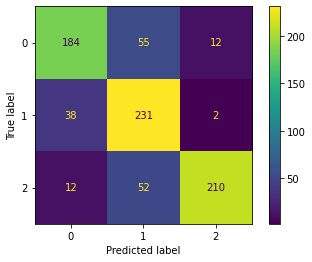

In [55]:
#Exibindo a matriz de confusão dos resultados preditos
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()

In [56]:
#Construindo a base do Pipeline
pipe_rf = Pipeline([('rf_RandomGrid', RandomForestClassifier(random_state=123))])


In [57]:
#Treinando o modelo com Pipeline
model = pipe_rf.fit(X_train, y_train)


In [58]:
#Calculando y_score
y_score = model.predict_proba(X_test)

In [59]:
#Declarando valores unicos de classes em ordem
n_binaries = y_test.unique()
n_binaries.sort()

#Binarizando a saída
y_test_bin = label_binarize(y_test, classes=n_binaries)
n_classes = y_test_bin.shape[1]


AUC for Class 1: 0.9177857377828136
AUC for Class 2: 0.8999718854331401
AUC for Class 3: 0.9209070951142435


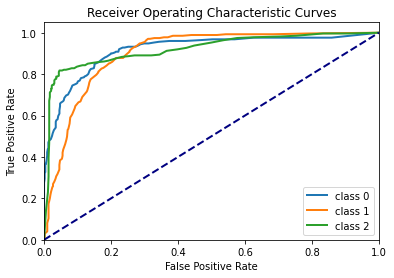

In [60]:
#Calculando e exibindo curva ROC das classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
  plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))
  print('AUC for Class {}: {}'.format(i+1, auc(fpr[i], tpr[i])))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--' )
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.show()